In [943]:
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import names
import random
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
import pandas as pd
import ast

from imdb import Cinemagoer
import matplotlib.pyplot as plt
import seaborn as sns

In [944]:
def movie_features(movie):
    features = {}
    features["budget"] = int(movie[16])
    features["runtimes"] = int(movie[4])
    if type(movie[13]) is list:
        features["director"] = movie[13][0]
    else:
        features["director"] = movie[13]
    if type(movie[11]) is list:
        features["composer"] = movie[11][0]
    else:
        features["composer"] = movie[11]
    if type(movie[9]) is list:
        features["cinematographer"] = movie[9][0]
    else:
        features["cinematographer"] = movie[9]
    # features["genres"] = tuple(movie[10])
    # features["cast"] = tuple(movie[2])
    return (features, int(movie[19]))

In [945]:
df = pd.read_csv('movies.csv') 
df = df[df["budget"].str.contains("INR") == False]
df = df[df["budget"].str.contains("EUR") == False]
df = df[df["budget"].str.contains("GBP") == False]
df = df[df["budget"].str.contains("BRL") == False]
df = df[df["budget"].str.contains("FRF") == False]
df = df[df["budget"].str.contains("JPY") == False]
df = df[df["budget"].str.contains("KRW") == False]
df = df[df["budget"].str.contains("AUD") == False]

df['worldwide_gross'] = df['worldwide_gross'].str.replace('$','')
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',','')
df['worldwide_gross'] = df['worldwide_gross'].apply(lambda x: str(x).split(' ')[0])
df['worldwide_gross'] = df['worldwide_gross'].astype('float')
df['budget'] = df['budget'].str.replace('$','')
df['budget'] = df['budget'].str.replace(',','')
df['budget'] = df['budget'].apply(lambda x: str(x).split(' ')[0])
df['budget'] = df['budget'].astype('float')

print(type(df["cast"][0]))
print(type(ast.literal_eval(df["cast"][0])))

df["cast"] = df.apply(lambda x: ast.literal_eval(x["cast"]), axis=1)
df["box_office"] = df.apply(lambda x: ast.literal_eval(x["box_office"]) if "[" in str(x["box_office"]) else x["box_office"], axis=1)
df["producer"] = df.apply(lambda x: ast.literal_eval(x["producer"]) if "[" in str(x["producer"]) else x["producer"], axis=1)
df["production_manager"] = df.apply(lambda x: ast.literal_eval(x["production_manager"]) if "[" in str(x["production_manager"]) else x["production_manager"], axis=1)
df["writer"] = df.apply(lambda x: ast.literal_eval(x["writer"]) if "[" in str(x["writer"]) else x["writer"], axis=1)
df["composer"] = df.apply(lambda x: ast.literal_eval(x["composer"]) if "[" in str(x["composer"]) else x["composer"], axis=1)
df["director"] = df.apply(lambda x: ast.literal_eval(x["director"]) if "[" in str(x["director"]) else x["director"], axis=1)
df["production_companies"] = df.apply(lambda x: ast.literal_eval(x["production_companies"]) if "[" in str(x["production_companies"]) else x["production_companies"], axis=1)

df['profit_ratio'] = df.apply(lambda x: (x["worldwide_gross"] / x["budget"]), axis=1)

# 1 = successful movie, 0 = failure movie
df['success'] = df.apply(lambda x: 1 if ((x["worldwide_gross"] / x["budget"]) > 2) else 0, axis=1)

# display(df)

df_list = df.values.tolist()

random.shuffle(df_list)

featuresets = [movie_features(movie) for movie in df_list]
print(featuresets)

train_set, test_set = train_test_split(featuresets)

classifier = nltk.NaiveBayesClassifier.train(train_set)

/tmp/ipykernel_1943/3317946103.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['worldwide_gross'] = df['worldwide_gross'].str.replace('$','')
/tmp/ipykernel_1943/3317946103.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['budget'] = df['budget'].str.replace('$','')


<class 'str'>
<class 'list'>
[({'budget': 30000000, 'runtimes': 90, 'director': 'James Mangold', 'composer': 'Alan Silvestri', 'cinematographer': 'Phedon Papamichael'}, 1), ({'budget': 50000000, 'runtimes': 112, 'director': 'J.J. Abrams', 'composer': 'Michael Giacchino', 'cinematographer': 'Larry Fong'}, 1), ({'budget': 50000000, 'runtimes': 130, 'director': 'Chris Weitz', 'composer': 'Alexandre Desplat', 'cinematographer': 'Javier Aguirresarobe'}, 1), ({'budget': 200000000, 'runtimes': 133, 'director': 'Gareth Edwards', 'composer': 'John Williams', 'cinematographer': 'Greig Fraser'}, 1), ({'budget': 44500000, 'runtimes': 120, 'director': 'Ben Affleck', 'composer': 'Alexandre Desplat', 'cinematographer': 'Rodrigo Prieto'}, 1), ({'budget': 10000000, 'runtimes': 93, 'director': 'Darren Lynn Bousman', 'composer': 'Charlie Clouser', 'cinematographer': 'David A. Armstrong'}, 1), ({'budget': 132000000, 'runtimes': 116, 'director': 'Steven Spielberg', 'composer': 'John Williams', 'cinematogra

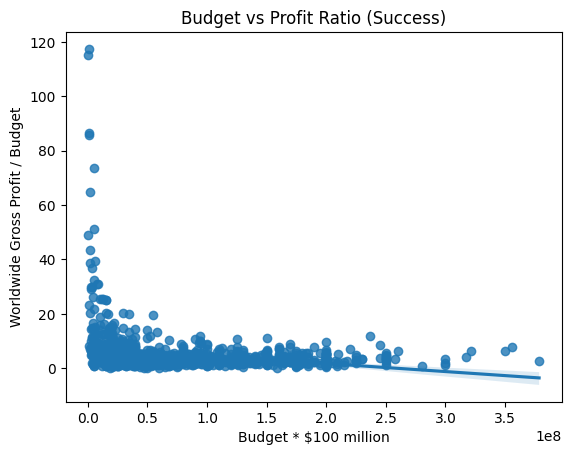

In [946]:
# Budget vs Success Ratio
budgetPlot = sns.regplot(data=df, x='budget', y='profit_ratio')

plt.title("Budget vs Profit Ratio (Success)")
plt.xlabel("Budget * $100 million")
plt.ylabel("Worldwide Gross Profit / Budget")
plt.savefig("budget_vs_profit_ratio.pdf")


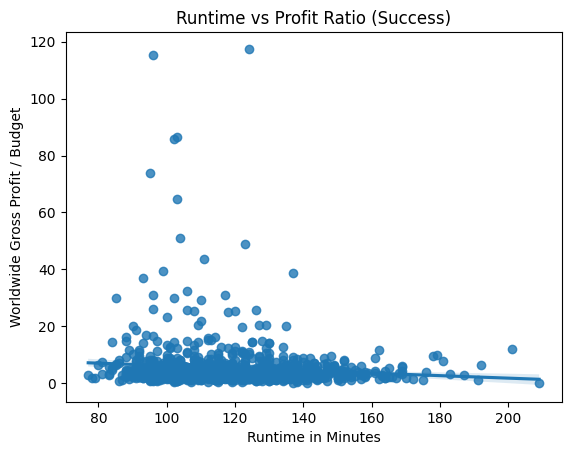

In [947]:
# Runtimes vs Success Ratio
runtimePlot = sns.regplot(data=df, x='runtimes', y='profit_ratio')

plt.title("Runtime vs Profit Ratio (Success)")
plt.xlabel("Runtime in Minutes")
plt.ylabel("Worldwide Gross Profit / Budget")
plt.savefig("runtime_vs_profit_ratio.pdf")

In [948]:
y_true = list(list(zip(*test_set))[1])
test_features = list(list(zip(*test_set))[0])
y_predict = [classifier.classify(features) for features in test_features]
(p,r,f,s) = precision_recall_fscore_support(y_true, y_predict, labels=[1])
print(p,r,f,s)

[0.83333333] [0.76732673] [0.79896907] [202]


In [949]:
classifier.show_most_informative_features(30)

Most Informative Features
         cinematographer = 'Dion Beebe'        0 : 1      =      7.5 : 1.0
                  budget = 68000000            0 : 1      =      6.7 : 1.0
         cinematographer = 'John Mathieson'      0 : 1      =      6.5 : 1.0
         cinematographer = 'David Tattersall'      0 : 1      =      5.8 : 1.0
         cinematographer = 'Emmanuel Lubezki'      0 : 1      =      5.8 : 1.0
                director = 'Martin Scorsese'      0 : 1      =      5.3 : 1.0
                director = 'Robert Zemeckis'      0 : 1      =      5.3 : 1.0
                director = 'Shane Black'       0 : 1      =      5.3 : 1.0
                director = 'Wes Anderson'      0 : 1      =      5.3 : 1.0
                  budget = 102000000           0 : 1      =      4.8 : 1.0
                composer = 'Daniel Pemberton'      0 : 1      =      4.8 : 1.0
                runtimes = 150                 0 : 1      =      4.5 : 1.0
                composer = 'Ilan Eshkeri'      0 : 1  